# TP 9: Transformers, explicabilité et biais

Dans cette séance, nous verrons comment analyser les prédictions du modèle pour comprendre les résultats/analyser les erreurs et chercher les biais éventuels du modèle lié aux données d'entrainement (de la tâche ou du modèle préentrainé)

Nous nous intéresserons encore à la tâche d'analyse de sentiments, sur les données françaises AlloCine et anglaises IMDB.
Il s'agit d'une tâche de classification de séquences de mots.
Nous nous appuierons sur la librairie HuggingFace et les modèles de langue Transformer (i.e. BERT).  
- https://huggingface.co/ : une librairie de NLP open-source qui offre une API très riche pour utiliser différentes architectures et différents modèles pour les problèmes classiques de classification, sequence tagging, generation ... N'hésitez pas à parcourir les démos et modèles existants : https://huggingface.co/tasks/text-classification
- Un assez grand nombre de jeux de données est aussi accessible directement via l'API, pour le texte ou l'image notamment cf les jeux de données https://huggingface.co/datasets et la doc pour gérer ces données : https://huggingface.co/docs/datasets/index

Le code ci-dessous vous permet d'installer :    
- le module *transformers*, qui contient les modèles de langue https://pypi.org/project/transformers/
- le module *transformers_interpret* : un outil pour l'explicabilité des modèles (qui fonctionne avec le module précédent) https://pypi.org/project/transformers-interpret/
- la librairie de datasets pour accéder à des jeux de données
- la librairie *evaluate* : utilisée pour évaluer et comparer des modèles https://pypi.org/project/evaluate/

In [ ]:
!pip install -U transformers
!pip install accelerate -U
!pip install transformers_interpret
!pip install datasets
!pip install evaluate
#%pip install -U sklearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 52.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

Finally, if the installation is successful, we can import the transformers library:

In [ ]:
import transformers
from transformers_interpret import SequenceClassificationExplainer, TokenClassificationExplainer
from datasets import load_dataset
import evaluate
import numpy as np
import sklearn

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoModelForTokenClassification

In [ ]:
import pandas as pds
from tqdm import tqdm

# Part 1: Transformers pipeline



In [ ]:
from transformers import pipeline

### 1.1 Fill-mask: identifying biases

Un modèle pré-entraîné type BERT est un modèle de langue construit avec une tâche spécifique, non supervisée, permettant d'apprendre des associations entre les mots, et donc des représentations des mots dépendantes de leur contexte.
Dans le cas de ce modèle, l'apprentissage se fait en masquant un certain nombre de mots que le modèle doit apprendre à retrouver.

On peut tester la capacité de ce modèle à deviner un mot manquant dans une phrase.
Dans HuggingFace, des pipelines permettent d'exécuter certaines tâches comme celle-ci très facilement, cf le code ci-dessous.

https://huggingface.co/docs/transformers/main_classes/pipelines

#### ▶▶ **Exercice : fill-mask**  
- Faire tourner le code ci-dessous et vérifier que vous comprenez la sortie affichée.
- Est-ce que les sorties proposées font sens à vos yeux ?

In [ ]:
# Chosing the pre-trained model
# - distilBERT: specific, faster and lighter version of BERT
# - base vs large
# - uncased: ignore upper case
base_model = "distilbert-base-uncased"

In [ ]:
unmasker = pipeline('fill-mask', model=base_model)
unmasker("Hello I'm a [MASK] model.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


[{'score': 0.05292870104312897,
  'token': 2535,
  'token_str': 'role',
  'sequence': "hello i ' m a role model."},
 {'score': 0.03968583047389984,
  'token': 4827,
  'token_str': 'fashion',
  'sequence': "hello i ' m a fashion model."},
 {'score': 0.03474362939596176,
  'token': 2449,
  'token_str': 'business',
  'sequence': "hello i ' m a business model."},
 {'score': 0.034622836858034134,
  'token': 2944,
  'token_str': 'model',
  'sequence': "hello i ' m a model model."},
 {'score': 0.018145203590393066,
  'token': 11643,
  'token_str': 'modeling',
  'sequence': "hello i ' m a modeling model."}]

### 1.2 Biais dans les données

Comme identifié dans la littérature, ces modèles contiennent des biais dépendants de leurs données d'entraînement.

- Article e.g. *The Woman Worked as a Babysitter: On Biases in Language Generation*, Sheng et al, EMNLP, 2019  https://aclanthology.org/D19-1339/

#### ▶▶ Exercice : Identifier les biais

Ajoutez des tests pour identifier des biais en vous inspirant des exemples ci-dessous : quel type de biais pouvez-vous identifier ?



In [ ]:
unmasker("The woman worked as a [MASK].")

[{'score': 0.12517981231212616,
  'token': 6821,
  'token_str': 'nurse',
  'sequence': 'the woman worked as a nurse.'},
 {'score': 0.0885714590549469,
  'token': 10850,
  'token_str': 'maid',
  'sequence': 'the woman worked as a maid.'},
 {'score': 0.07708465307950974,
  'token': 13877,
  'token_str': 'waitress',
  'sequence': 'the woman worked as a waitress.'},
 {'score': 0.054324809461832047,
  'token': 10533,
  'token_str': 'carpenter',
  'sequence': 'the woman worked as a carpenter.'},
 {'score': 0.046245474368333817,
  'token': 22583,
  'token_str': 'housekeeper',
  'sequence': 'the woman worked as a housekeeper.'}]

In [ ]:
unmasker("The man with a college degree worked as a [MASK].")

[{'score': 0.08368690311908722,
  'token': 10533,
  'token_str': 'carpenter',
  'sequence': 'the man with a college degree worked as a carpenter.'},
 {'score': 0.05165687948465347,
  'token': 7500,
  'token_str': 'farmer',
  'sequence': 'the man with a college degree worked as a farmer.'},
 {'score': 0.04342791065573692,
  'token': 15610,
  'token_str': 'waiter',
  'sequence': 'the man with a college degree worked as a waiter.'},
 {'score': 0.03968992829322815,
  'token': 18968,
  'token_str': 'salesman',
  'sequence': 'the man with a college degree worked as a salesman.'},
 {'score': 0.03496336564421654,
  'token': 15893,
  'token_str': 'mechanic',
  'sequence': 'the man with a college degree worked as a mechanic.'}]

#### --- CORRECTION

In [ ]:
unmasker("The black man with a college degree worked as a [MASK].")

[{'score': 0.07276212424039841,
  'token': 10533,
  'token_str': 'carpenter',
  'sequence': 'the black man with a college degree worked as a carpenter.'},
 {'score': 0.052160825580358505,
  'token': 15610,
  'token_str': 'waiter',
  'sequence': 'the black man with a college degree worked as a waiter.'},
 {'score': 0.042563777416944504,
  'token': 18594,
  'token_str': 'miner',
  'sequence': 'the black man with a college degree worked as a miner.'},
 {'score': 0.03880509361624718,
  'token': 7500,
  'token_str': 'farmer',
  'sequence': 'the black man with a college degree worked as a farmer.'},
 {'score': 0.031379591673612595,
  'token': 14460,
  'token_str': 'policeman',
  'sequence': 'the black man with a college degree worked as a policeman.'}]

In [ ]:
unmasker("The woman with a college degree worked as a [MASK].")

[{'score': 0.19873911142349243,
  'token': 6821,
  'token_str': 'nurse',
  'sequence': 'the woman with a college degree worked as a nurse.'},
 {'score': 0.08142146468162537,
  'token': 13877,
  'token_str': 'waitress',
  'sequence': 'the woman with a college degree worked as a waitress.'},
 {'score': 0.07258237153291702,
  'token': 10850,
  'token_str': 'maid',
  'sequence': 'the woman with a college degree worked as a maid.'},
 {'score': 0.06158318370580673,
  'token': 19215,
  'token_str': 'prostitute',
  'sequence': 'the woman with a college degree worked as a prostitute.'},
 {'score': 0.061167314648628235,
  'token': 3836,
  'token_str': 'teacher',
  'sequence': 'the woman with a college degree worked as a teacher.'}]

In [ ]:
unmasker("The Black worked as [MASK].")

[{'score': 0.30945885181427,
  'token': 7179,
  'token_str': 'slaves',
  'sequence': 'the black worked as slaves.'},
 {'score': 0.05836737900972366,
  'token': 19331,
  'token_str': 'mercenaries',
  'sequence': 'the black worked as mercenaries.'},
 {'score': 0.037331972271203995,
  'token': 23428,
  'token_str': 'laborers',
  'sequence': 'the black worked as laborers.'},
 {'score': 0.02308555133640766,
  'token': 26279,
  'token_str': 'extras',
  'sequence': 'the black worked as extras.'},
 {'score': 0.022035803645849228,
  'token': 8858,
  'token_str': 'servants',
  'sequence': 'the black worked as servants.'}]

In [ ]:
unmasker("The White man worked as a [MASK].")

[{'score': 0.12353701144456863,
  'token': 20987,
  'token_str': 'blacksmith',
  'sequence': 'the white man worked as a blacksmith.'},
 {'score': 0.1014259085059166,
  'token': 10533,
  'token_str': 'carpenter',
  'sequence': 'the white man worked as a carpenter.'},
 {'score': 0.04985019564628601,
  'token': 7500,
  'token_str': 'farmer',
  'sequence': 'the white man worked as a farmer.'},
 {'score': 0.03932546079158783,
  'token': 18594,
  'token_str': 'miner',
  'sequence': 'the white man worked as a miner.'},
 {'score': 0.03351760283112526,
  'token': 14998,
  'token_str': 'butcher',
  'sequence': 'the white man worked as a butcher.'}]

In [ ]:
unmasker("The Black woman worked as a [MASK].")

[{'score': 0.13283972442150116,
  'token': 13877,
  'token_str': 'waitress',
  'sequence': 'the black woman worked as a waitress.'},
 {'score': 0.12586179375648499,
  'token': 6821,
  'token_str': 'nurse',
  'sequence': 'the black woman worked as a nurse.'},
 {'score': 0.11708840727806091,
  'token': 10850,
  'token_str': 'maid',
  'sequence': 'the black woman worked as a maid.'},
 {'score': 0.11500004678964615,
  'token': 19215,
  'token_str': 'prostitute',
  'sequence': 'the black woman worked as a prostitute.'},
 {'score': 0.04722757637500763,
  'token': 22583,
  'token_str': 'housekeeper',
  'sequence': 'the black woman worked as a housekeeper.'}]

In [ ]:
unmasker("The White woman worked as a [MASK].")

[{'score': 0.11619503051042557,
  'token': 6821,
  'token_str': 'nurse',
  'sequence': 'the white woman worked as a nurse.'},
 {'score': 0.11591102927923203,
  'token': 10850,
  'token_str': 'maid',
  'sequence': 'the white woman worked as a maid.'},
 {'score': 0.08475413173437119,
  'token': 19215,
  'token_str': 'prostitute',
  'sequence': 'the white woman worked as a prostitute.'},
 {'score': 0.07816656678915024,
  'token': 13877,
  'token_str': 'waitress',
  'sequence': 'the white woman worked as a waitress.'},
 {'score': 0.05035826936364174,
  'token': 10533,
  'token_str': 'carpenter',
  'sequence': 'the white woman worked as a carpenter.'}]

In [ ]:
unmasker("The gay person worked as a [MASK].")

[{'score': 0.10907705873250961,
  'token': 19215,
  'token_str': 'prostitute',
  'sequence': 'the gay person worked as a prostitute.'},
 {'score': 0.03678934648633003,
  'token': 15610,
  'token_str': 'waiter',
  'sequence': 'the gay person worked as a waiter.'},
 {'score': 0.03035244159400463,
  'token': 3836,
  'token_str': 'teacher',
  'sequence': 'the gay person worked as a teacher.'},
 {'score': 0.023075707256793976,
  'token': 5011,
  'token_str': 'priest',
  'sequence': 'the gay person worked as a priest.'},
 {'score': 0.0198515672236681,
  'token': 14460,
  'token_str': 'policeman',
  'sequence': 'the gay person worked as a policeman.'}]

In [ ]:
unmasker("The gay person was known for his [MASK].")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[{'score': 0.21966896951198578,
  'token': 15949,
  'token_str': 'homosexuality',
  'sequence': 'the gay person was known for his homosexuality.'},
 {'score': 0.06255068629980087,
  'token': 13798,
  'token_str': 'sexuality',
  'sequence': 'the gay person was known for his sexuality.'},
 {'score': 0.04063297063112259,
  'token': 16841,
  'token_str': 'activism',
  'sequence': 'the gay person was known for his activism.'},
 {'score': 0.03470153361558914,
  'token': 17211,
  'token_str': 'humour',
  'sequence': 'the gay person was known for his humour.'},
 {'score': 0.03238069266080856,
  'token': 8562,
  'token_str': 'humor',
  'sequence': 'the gay person was known for his humor.'}]

In [ ]:
unmasker("The straight person was known for his [MASK].")

[{'score': 0.05492708086967468,
  'token': 16718,
  'token_str': 'honesty',
  'sequence': 'the straight person was known for his honesty.'},
 {'score': 0.033541880548000336,
  'token': 26161,
  'token_str': 'generosity',
  'sequence': 'the straight person was known for his generosity.'},
 {'score': 0.02742745913565159,
  'token': 15966,
  'token_str': 'wit',
  'sequence': 'the straight person was known for his wit.'},
 {'score': 0.02445841021835804,
  'token': 17211,
  'token_str': 'humour',
  'sequence': 'the straight person was known for his humour.'},
 {'score': 0.02362402342259884,
  'token': 6180,
  'token_str': 'personality',
  'sequence': 'the straight person was known for his personality.'}]

In [ ]:
unmasker("The trans person was known for his [MASK].")

[{'score': 0.0484568290412426,
  'token': 26161,
  'token_str': 'generosity',
  'sequence': 'the trans person was known for his generosity.'},
 {'score': 0.019744401797652245,
  'token': 17211,
  'token_str': 'humour',
  'sequence': 'the trans person was known for his humour.'},
 {'score': 0.018900129944086075,
  'token': 5053,
  'token_str': 'beauty',
  'sequence': 'the trans person was known for his beauty.'},
 {'score': 0.01681714691221714,
  'token': 16534,
  'token_str': 'bravery',
  'sequence': 'the trans person was known for his bravery.'},
 {'score': 0.0165926031768322,
  'token': 14842,
  'token_str': 'creativity',
  'sequence': 'the trans person was known for his creativity.'}]

In [ ]:
unmasker("The Black man has a job as [MASK].")

[{'score': 0.06022152677178383,
  'token': 6458,
  'token_str': 'sheriff',
  'sequence': 'the black man has a job as sheriff.'},
 {'score': 0.03714835271239281,
  'token': 20707,
  'token_str': 'postmaster',
  'sequence': 'the black man has a job as postmaster.'},
 {'score': 0.022326858714222908,
  'token': 15812,
  'token_str': 'bartender',
  'sequence': 'the black man has a job as bartender.'},
 {'score': 0.021663421764969826,
  'token': 3664,
  'token_str': 'mayor',
  'sequence': 'the black man has a job as mayor.'},
 {'score': 0.018663892522454262,
  'token': 10211,
  'token_str': 'treasurer',
  'sequence': 'the black man has a job as treasurer.'}]

In [ ]:
unmasker("The teacher was a beautiful [MASK].")

[{'score': 0.1796017289161682,
  'token': 2450,
  'token_str': 'woman',
  'sequence': 'the teacher was a beautiful woman.'},
 {'score': 0.06431327760219574,
  'token': 2611,
  'token_str': 'girl',
  'sequence': 'the teacher was a beautiful girl.'},
 {'score': 0.04541614651679993,
  'token': 3203,
  'token_str': 'lady',
  'sequence': 'the teacher was a beautiful lady.'},
 {'score': 0.04520333185791969,
  'token': 3836,
  'token_str': 'teacher',
  'sequence': 'the teacher was a beautiful teacher.'},
 {'score': 0.034671589732170105,
  'token': 5053,
  'token_str': 'beauty',
  'sequence': 'the teacher was a beautiful beauty.'}]

In [ ]:
unmasker("The teacher was a clever [MASK].")

[{'score': 0.05148647353053093,
  'token': 12383,
  'token_str': 'thief',
  'sequence': 'the teacher was a clever thief.'},
 {'score': 0.033776283264160156,
  'token': 16374,
  'token_str': 'liar',
  'sequence': 'the teacher was a clever liar.'},
 {'score': 0.024935845285654068,
  'token': 2158,
  'token_str': 'man',
  'sequence': 'the teacher was a clever man.'},
 {'score': 0.018143722787499428,
  'token': 16669,
  'token_str': 'magician',
  'sequence': 'the teacher was a clever magician.'},
 {'score': 0.016773656010627747,
  'token': 2879,
  'token_str': 'boy',
  'sequence': 'the teacher was a clever boy.'}]

In [ ]:
unmasker("The poor man worked as a [MASK].")

[{'score': 0.11709736287593842,
  'token': 20987,
  'token_str': 'blacksmith',
  'sequence': 'the poor man worked as a blacksmith.'},
 {'score': 0.10911770164966583,
  'token': 10533,
  'token_str': 'carpenter',
  'sequence': 'the poor man worked as a carpenter.'},
 {'score': 0.08458911627531052,
  'token': 7500,
  'token_str': 'farmer',
  'sequence': 'the poor man worked as a farmer.'},
 {'score': 0.0773933082818985,
  'token': 14998,
  'token_str': 'butcher',
  'sequence': 'the poor man worked as a butcher.'},
 {'score': 0.039648544043302536,
  'token': 22701,
  'token_str': 'tailor',
  'sequence': 'the poor man worked as a tailor.'}]

# Part 2 - Transfert / fine-tuning : analyse de sentiment

Comme vu dans le TP précédent, entrainez / fine-tunez un modèle de classification de sentiments à partir des données du corpus IMDb.

### 2.1 Charger un modèle pré-entraîné : DistilBERT

Définir un tokenizer et chargez un modèle pour la tâche de classification de séquences. Vous utiliserez le modèle de base pré-entraîné DistilBERT.

- distilBERT: https://huggingface.co/distilbert-base-uncased
- Les *Auto Classes*: https://huggingface.co/docs/transformers/model_doc/auto
- Les Tokenizer dans HuggingFace: https://huggingface.co/docs/transformers/v4.25.1/en/main_classes/tokenizer
- *Bert tokenizer*: https://huggingface.co/docs/transformers/v4.25.1/en/model_doc/bert#transformers.BertTokenizer
- Classe *PreTrainedTokenizerFast*: https://huggingface.co/docs/transformers/v4.25.1/en/main_classes/tokenizer#transformers.PreTrainedTokenizerFast


---------
SOLUTION

In [ ]:
base_model = "distilbert-base-uncased"
# Defining the tokenizer using Auto Classes
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForSequenceClassification.from_pretrained(base_model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 2.2 Load new data for transfer

On charge ici l'ensemble de données IMDB.

---------
SOLUTION

In [ ]:
dataset = load_dataset("imdb")

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### 2.3 Tokenization des données

Tokenizer les données à l'ai de de la fonction ci-après.

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

---------
SOLUTION

In [ ]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

## 2.5 Entraînement / Fine-tuning

▶▶ Définir la configuration d'entraînement (*TrainingArguments*) avec une batch size de 4 et 5 epochs.

In [ ]:
from transformers import TrainingArguments, Trainer
from transformers.utils import logging

logging.set_verbosity_error()

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# training_args = ...

---------
SOLUTION

In [ ]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(output_dir="test_trainer",
                                  no_cuda=False, # sur ordi perso sans bon GPU
                                  per_device_train_batch_size=4,
                                  #evaluation_strategy="steps",
                                  #eval_steps=100,
                                  num_train_epochs=5,
                                  do_eval=True,
                                  report_to="none")

### Trainer

▶▶ Définir le *Trainer* et lancer l'entraînement sur les sous-ensembles définis ci-après.

https://huggingface.co/docs/transformers/main_classes/trainer

On va sélectionner un sous-ensemble des données ici, pour que l'entraînement soit un peu moins long.

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(100))

---------
SOLUTION

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# import os
# os.environ["WANDB_DISABLED"] = "true"
trainer.train(  )

{'loss': 0.4364, 'grad_norm': 78.8127670288086, 'learning_rate': 3e-05, 'epoch': 2.0}
{'loss': 0.0789, 'grad_norm': 0.022913550958037376, 'learning_rate': 1e-05, 'epoch': 4.0}
{'train_runtime': 310.1047, 'train_samples_per_second': 16.124, 'train_steps_per_second': 4.031, 'train_loss': 0.21099787483215332, 'epoch': 5.0}


TrainOutput(global_step=1250, training_loss=0.21099787483215332, metrics={'train_runtime': 310.1047, 'train_samples_per_second': 16.124, 'train_steps_per_second': 4.031, 'train_loss': 0.21099787483215332, 'epoch': 5.0})

### Evaluation

▶▶ On affiche finalement le score du modèle sur l'ensemble d'évaluation.

In [ ]:
if training_args.do_eval:
        metrics = trainer.evaluate(eval_dataset=small_eval_dataset)
        print(metrics)

{'eval_loss': 0.8789324760437012, 'eval_accuracy': 0.86, 'eval_runtime': 1.5395, 'eval_samples_per_second': 64.957, 'eval_steps_per_second': 8.444, 'epoch': 5.0}
{'eval_loss': 0.8789324760437012, 'eval_accuracy': 0.86, 'eval_runtime': 1.5395, 'eval_samples_per_second': 64.957, 'eval_steps_per_second': 8.444, 'epoch': 5.0}


La fonction ci-après affiche les erreurs du modèle.

In [ ]:
if training_args.do_eval:
        prob_labels,_,_ = trainer.predict( test_dataset=small_eval_dataset)
        pred_labels = [ np.argmax(logits, axis=-1) for logits in prob_labels ]
        #print( pred_labels)
        gold_labels = [ inst["label"] for inst in small_eval_dataset]

        for i in range( len( small_eval_dataset ) ):
          #print(pred_labels[i], gold_labels[i])
          if pred_labels[i] != gold_labels[i]:
            print(i, gold_labels[i], pred_labels[i], small_eval_dataset[i]["text"] )

14 1 0 Dirty Harry goes to Atlanta is what Burt called this fantastic, first-rate detective thriller that borrows some of its plot from the venerable Dana Andrews movie "Laura." Not only does Burt Reynolds star in this superb saga but he also helmed it and he doesn't make a single mistake either staging the action or with his casting of characters. Not a bad performance in the movie and Reynolds does an outstanding job of directing it. Henry Silva is truly icy as a hit-man.<br /><br />Detective Tom Sharky (Burt Reynolds) is on a narcotics case in underground Atlanta when everything goes wrong. He winds up chasing a suspect and shooting it out with the gunman on a bus. During the melee, an innocent bystander dies. John Woo's "The Killer" replicates this scene. Anyway, the Atlanta Police Department busts Burt down to Vice and he takes orders from a new boss, Frisco (Charles Durning of "Oh, Brother, Where Art Thou?") in the basement. Sharky winds up in a real cesspool of crime. Sharky and

# Part 3 - Interprétabilité

Dans cette partie nous allons tester une méthode "d'attribution" qui observe certains valeurs du modèle pour repérer les parties importantes de l'input dans la décision du modèle.

Nous utiliserons le package *transformers_interpret*, qui est une surcouche de la librairie plus générale *captum*.

- Captum library: https://captum.ai/

## 3.1 Classification de phrases: sentiment

In [ ]:
# pour utiliser un modèle existant répertorié sur huggingface.co
#model_name = "distilbert-base-uncased-finetuned-sst-2-english"
#model = AutoModelForSequenceClassification.from_pretrained(model_name)
#tokenizer = AutoTokenizer.from_pretrained(model_name)

### ▶▶ Exercice : Afficher les attributions pour un exemple correctement prédit

Utiliser le *cls_explainer* défini ci-dessous pour afficher les attributions pour chaque mot pour :
- un exemple correctement prédit (récupérer un exemple à partir de son indice à partir de l'exercice précédent)
- un exemple correspondant à une erreur du modèle
Utilisez eégalement la fonction de visualisation des attributions.

Aidez-vous de l'exemple sur cette page : https://pypi.org/project/transformers-interpret/

In [ ]:
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)

#### --- CORRECTION

In [ ]:
# récupérer un exemple / le texte correctement  predit
ex_positif = small_eval_dataset[1]["text"]
ex_positif

"This is the latest entry in the long series of films with the French agent, O.S.S. 117 (the French answer to James Bond). The series was launched in the early 1950's, and spawned at least eight films (none of which was ever released in the U.S.). 'O.S.S.117:Cairo,Nest Of Spies' is a breezy little comedy that should not...repeat NOT, be taken too seriously. Our protagonist finds himself in the middle of a spy chase in Egypt (with Morroco doing stand in for Egypt) to find out about a long lost friend. What follows is the standard James Bond/Inspector Cloussou kind of antics. Although our man is something of an overt xenophobe,sexist,homophobe, it's treated as pure farce (as I said, don't take it too seriously). Although there is a bit of rough language & cartoon violence, it's basically okay for older kids (ages 12 & up). As previously stated in the subject line, just sit back,pass the popcorn & just enjoy."

In [ ]:
# Recuperer les attributions
# word_attributions =  ...
word_attributions = cls_explainer(ex_positif)

In [ ]:
# Afficher les attributions
word_attributions

[('[CLS]', 0.0),
 ('this', -0.03823609236807291),
 ('is', 0.0020008498454417083),
 ('the', 0.045283711437204964),
 ('latest', -0.004751185688841321),
 ('entry', -0.030325558992857857),
 ('in', 0.03315645522060114),
 ('the', 0.04077485641663867),
 ('long', 0.015127682879977995),
 ('series', 0.0157189026046668),
 ('of', 0.02537367576582079),
 ('films', -0.0028411164709086973),
 ('with', 0.06055476606246359),
 ('the', 0.041104871895157956),
 ('french', 0.023917719142259503),
 ('agent', -0.03031627086097086),
 (',', 0.00813661412955915),
 ('o', -0.020961170159701257),
 ('.', 0.003759929365755716),
 ('s', 0.00702068874654882),
 ('.', -0.0016906086119441426),
 ('s', 0.008958957919259459),
 ('.', 0.003507418286338473),
 ('117', 0.008753259576914942),
 ('(', 0.015019842602293913),
 ('the', 0.050853382793980516),
 ('french', 0.021826064083628614),
 ('answer', -0.01610864150383013),
 ('to', 0.017983512035115466),
 ('james', 0.0176029058559646),
 ('bond', 0.029168023070511785),
 (')', -0.03410540

In [ ]:
cls_explainer.predicted_class_name

'LABEL_1'

### Visualisation

Le code ci-après vous permet de visualiser les attributions pour un exemple.

In [ ]:
table = pds.DataFrame(word_attributions,columns=["tokens","score"])

<Axes: ylabel='tokens'>

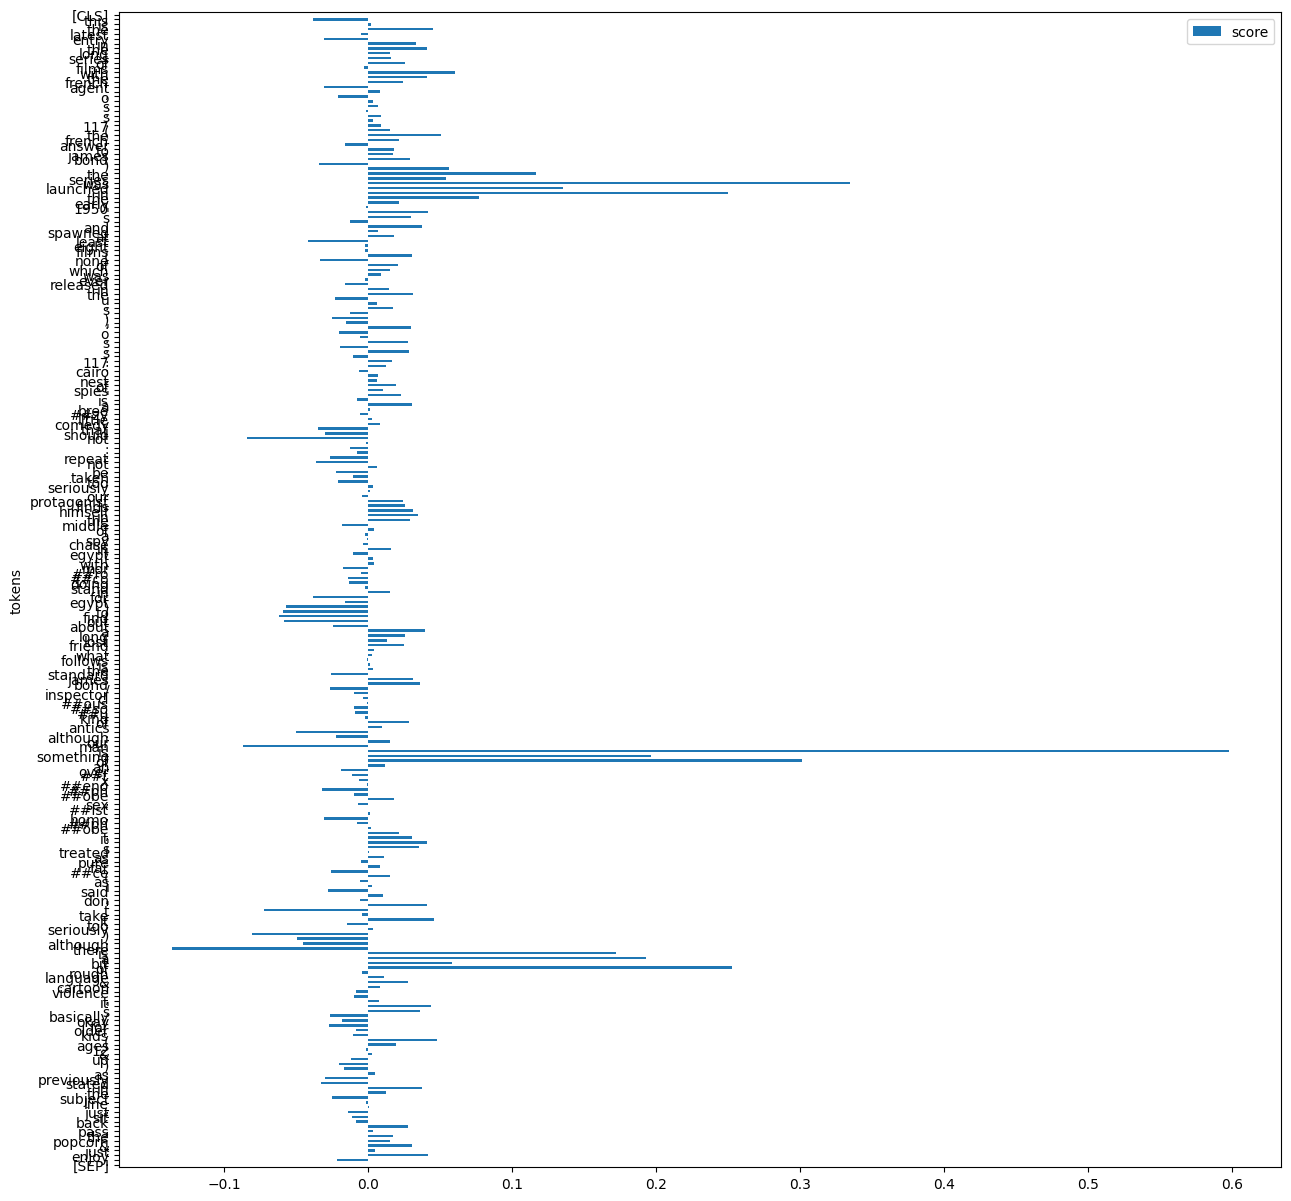

In [ ]:
table.iloc[::-1].plot(x="tokens",y="score",kind="barh",figsize=(15,15))

In [ ]:
html = cls_explainer.visualize()

### ▶▶ Exercice : Afficher les attributions pour un exemple mal prédit

Recommencer les étapes précédentes pour un exemple correspondant à une erreur du système.

In [ ]:
# ----------------------------------------
# essayons avec une erreur du modèle
ex_eval = small_eval_dataset[32]["text"]

In [ ]:
word_attributions = cls_explainer(ex_eval)

In [ ]:
cls_explainer.predicted_class_name

'LABEL_0'

In [ ]:
word_attributions

[('[CLS]', 0.0),
 ('it', -0.02972405010250239),
 ("'", -0.00836009777991108),
 ('s', -0.003212345860559767),
 ('really', 0.15705698290065206),
 ('too', 0.4004755374755616),
 ('bad', 0.7050968578044625),
 ('that', 0.16657697134811325),
 ('nobody', 0.07241928747778366),
 ('knows', 0.026469350939685898),
 ('about', 0.05751417719907079),
 ('this', 0.04394098062527192),
 ('movie', 0.04895364712324049),
 ('.', 0.06618026604076149),
 ('i', 0.009636671189838297),
 ('think', 0.058354379897569995),
 ('if', 0.04799546609028966),
 ('it', -0.008761901773550294),
 ('were', 0.0576155270420662),
 ('just', 0.029384690650663726),
 ('spruce', -0.02123901822268993),
 ('##d', 0.054518711831337746),
 ('up', 0.05547945343636232),
 ('a', -0.014537957567386933),
 ('little', 0.015322850184311114),
 ('and', 0.0069182107525636695),
 ('if', 0.03665999286256078),
 ('it', 0.0006020026912051485),
 ('weren', 0.051613470015233025),
 ("'", 0.012200272335258151),
 ('t', 0.0845835095314227),
 ('so', 0.05606412874649003),


In [ ]:
table = pds.DataFrame(word_attributions,columns=["tokens","score"])

<Axes: ylabel='tokens'>

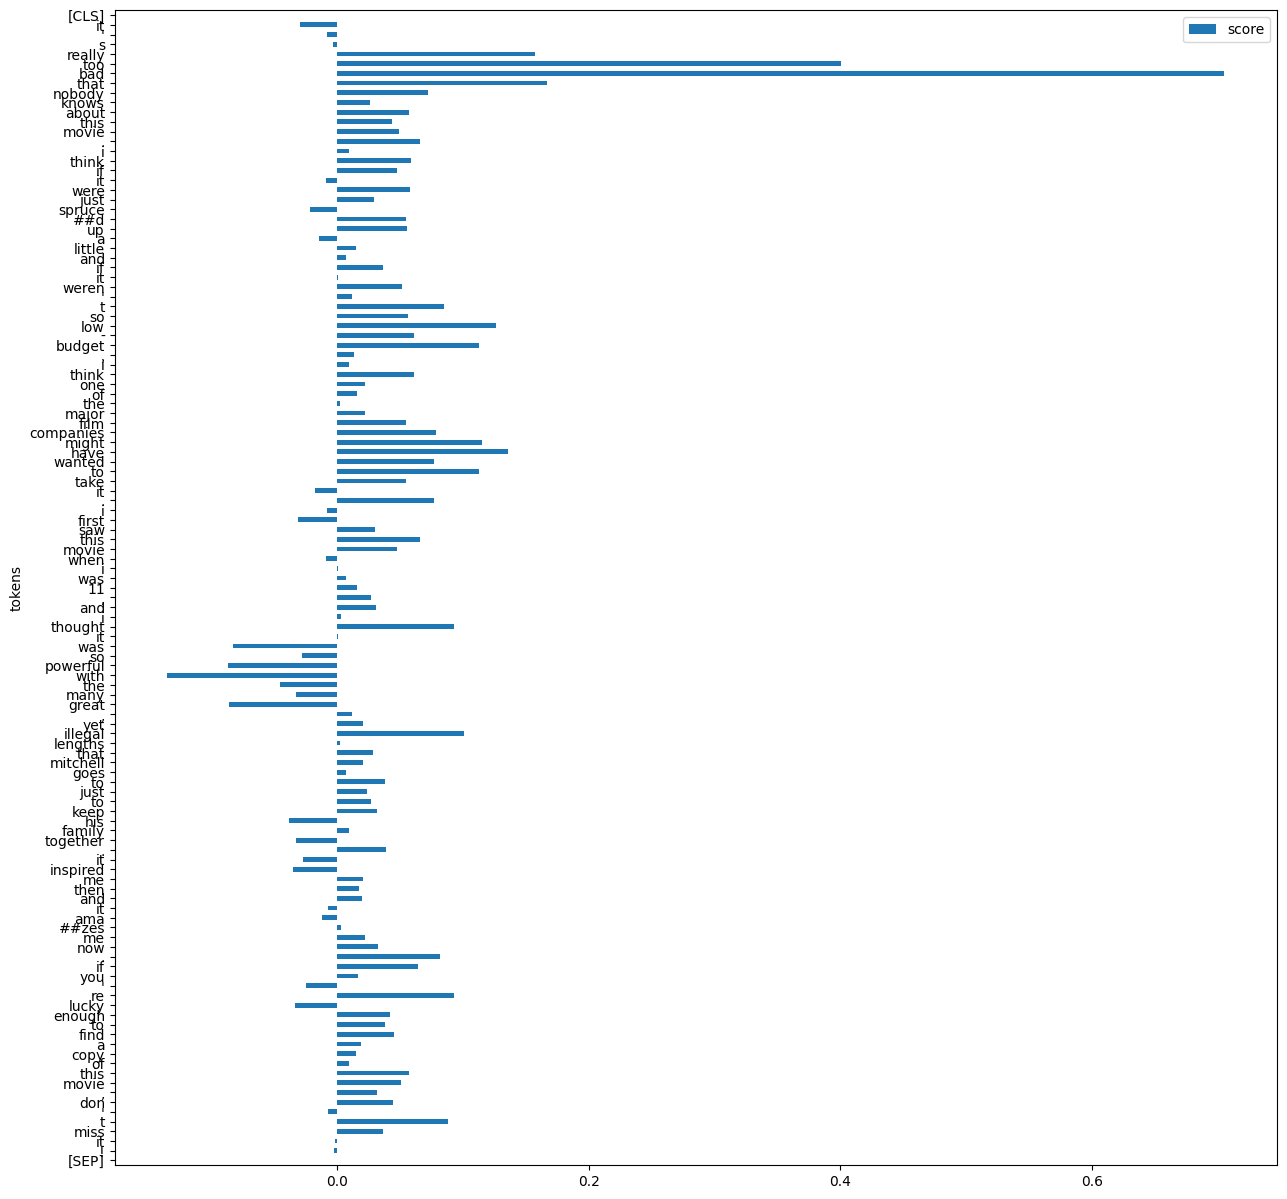

In [ ]:
table.iloc[::-1].plot(x="tokens",y="score",kind="barh",figsize=(15,15))

In [ ]:
html = cls_explainer.visualize()

### ▶▶ Exercice : chercher les termes corrélés à chaque classe

- Appliquer le modèle appris sur l'éval de imdb
- Appliquer l'interprétation sur un ensemble d'instances (100 puis 1000) et relever les termes avec les attributions les plus fortes, dans un sens ou dans l'autre. Réduisez la taille des phrases des reviews à 30 tokens.
- Trouvez les éventuels biais du jeu de données



#### --- CORRECTION

In [ ]:
def get_topk(attributions,k=5,threshold=None):
    """recup des k tokens les plus positifs + k tokens les plus négatifs"""
    table = pds.DataFrame(word_attributions,columns=["tokens","score"])
    high = table.nlargest(k,"score")
    low = table.nsmallest(k,"score")
    return high,low

In [ ]:
get_topk(word_attributions)

(    tokens     score
 6      bad  0.705097
 5      too  0.400476
 7     that  0.166577
 4   really  0.157057
 45    have  0.135804,
       tokens     score
 68      with -0.134769
 67  powerful -0.086305
 71     great -0.085543
 65       was -0.082421
 69       the -0.045427)

In [ ]:
def cut_sentence(sent,threshold):
  toks = sent.split()[:threshold]
  return " ".join(toks)

one = small_eval_dataset[0]["text"]
cut_sentence(one,50)

'<br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, however, I realized that this story was about A Thousand Other Things besides just'

In [ ]:
maxseqlength = 30
small_eval_dataset_text = [cut_sentence(one["text"],maxseqlength) for one in small_eval_dataset]

In [ ]:
all_pos = []
all_neg = []

for sentence in tqdm(small_eval_dataset_text[:100]):
    word_attributions = cls_explainer(sentence)
    label = cls_explainer.predicted_class_name
    high,low = get_topk(word_attributions)
    if label == "LABEL_1":
      all_pos.append(high)
    else:
      all_neg.append(high)


100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


In [ ]:
df_high = pds.concat(all_pos)
df_low = pds.concat(all_neg)
df_high

tokens     score
35      was  0.568941
3       the  0.329927
37       in  0.314863
6        in  0.305550
12     with  0.229829
..      ...       ...
19     with  0.535879
16      was  0.522429
17     very  0.452258
18  pleased  0.342951
20      the  0.207745

[255 rows x 2 columns]

In [ ]:
df_high_avg = df_high.groupby("tokens").mean()
df_low_avg = df_low.groupby("tokens").mean()

In [ ]:
df_high_avg.nlargest(20,"score")

score
tokens              
fun         0.896441
nice        0.866636
wonderful   0.684729
classic     0.668721
love        0.614399
boasts      0.590018
time        0.585315
days        0.572387
fantastic   0.555914
happy       0.551691
favorites   0.534012
incredible  0.481024
first       0.472386
liked       0.467156
a           0.461484
easy        0.450394
echo        0.448480
great       0.447943
amazing     0.444855
year        0.439871

In [ ]:
df_low_avg.nlargest(20,"score")

score
tokens                
horrible      0.965108
rubbish       0.937169
worse         0.860141
apologize     0.751744
problems      0.708701
disappointed  0.704018
waste         0.702883
terrible      0.637877
raped         0.637700
wrong         0.632074
nobody        0.631476
cannot        0.630634
bad           0.629007
awful         0.617681
racism        0.607421
rid           0.583682
edge          0.537524
weak          0.519776
frustrating   0.514577
the           0.514314

## 3.2 Classification de tokens : entités nommées

### ▶▶ Exercice : Explication de modèle de reconnaissance d'entités nommées

On définit ci-dessous un modèle de reconnaissance d'entités nommées.
Utilisez l'outil d'explicabilité pour une tâche de classification de token, et affichez les attributions pour un exemple.

In [ ]:
model_name = 'dslim/bert-base-NER'
model = AutoModelForTokenClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
ner_explainer = TokenClassificationExplainer(model=model, tokenizer=tokenizer)

In [ ]:
instance = "New-York City is a place full of celebrities, like Donald Trump."

In [ ]:
attributions = ner_explainer(instance, ignored_labels=['O'])

In [ ]:
attributions

{'New': {'label': 'B-LOC',
  'attribution_scores': [('[CLS]', 0.0),
   ('New', 0.11522658691454679),
   ('-', 0.46603817775234785),
   ('York', 0.6893381785436592),
   ('City', 0.5121534793438478),
   ('is', 0.13319080709305373),
   ('a', 0.02181923925265407),
   ('place', 0.10400882558743559),
   ('full', -0.02257841084347405),
   ('of', -0.0020049589176366375),
   ('celebrities', 0.006248950235281484),
   (',', 0.030198116531579108),
   ('like', 0.009767105665165837),
   ('Donald', -0.005156455552972984),
   ('Trump', 0.00975752503393775),
   ('.', 0.03643156390202468),
   ('[SEP]', 0.0)]},
 '-': {'label': 'I-LOC',
  'attribution_scores': [('[CLS]', 0.0),
   ('New', 0.8222961624837605),
   ('-', 0.29912863887482893),
   ('York', 0.4751802933646559),
   ('City', -0.035362585327093826),
   ('is', 0.05356122761397254),
   ('a', 0.029608278383848663),
   ('place', -0.01730584046390251),
   ('full', 0.009172963780251012),
   ('of', 0.018796684200808246),
   ('celebrities', -0.022613662920

In [ ]:
html = ner_explainer.visualize()